# PARTIE 2 : ANALYSES TEMPORELLES - S&P 500

Analyse des tendances temporelles des actions du S&P 500

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from scipy.interpolate import make_interp_spline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set3")
%matplotlib inline

In [8]:
# Stocks à analyser
sp500_symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "BRK.B", "JNJ", "V",
    "WMT", "JPM", "PG", "MA", "UNH", "HD", "DIS", "CRM", "MCD", "KO",
    "NFLX", "CSCO", "PEP", "ABT", "ABBV", "MMM", "XOM", "CVX", "BA", "COST",
    "AMD", "INTC", "QCOM", "PYPL", "TXN", "ADBE", "IBM", "AVGO", "ACN", "GILD",
    "CDNS", "MRVL", "OKTA", "CCI", "ANET", "SNPS", "ASML", "NOW", "PANW", "LRCX"
]

sector_info = pd.DataFrame({
    'symbol': ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "BRK.B", "JNJ", "V",
               "WMT", "JPM", "PG", "MA", "UNH", "HD", "DIS", "CRM", "MCD", "KO",
               "NFLX", "CSCO", "PEP", "ABT", "ABBV", "MMM", "XOM", "CVX", "BA", "COST",
               "AMD", "INTC", "QCOM", "PYPL", "TXN", "ADBE", "IBM", "AVGO", "ACN", "GILD",
               "CDNS", "MRVL", "OKTA", "CCI", "ANET", "SNPS", "ASML", "NOW", "PANW", "LRCX"],
    'sector': ["Technology", "Technology", "Technology", "Consumer", "Technology", "Technology", "Consumer", "Finance", "Healthcare", "Finance",
               "Consumer", "Finance", "Consumer", "Finance", "Healthcare", "Consumer", "Consumer", "Technology", "Consumer", "Consumer",
               "Technology", "Technology", "Consumer", "Healthcare", "Healthcare", "Industrial", "Energy", "Energy", "Industrial", "Consumer",
               "Technology", "Technology", "Technology", "Finance", "Technology", "Technology", "Technology", "Technology", "Technology", "Healthcare",
               "Technology", "Technology", "Technology", "Real Estate", "Technology", "Technology", "Technology", "Technology", "Technology", "Technology"]
})

In [9]:
# Récupérer les données
print("Récupération des données S&P 500...")
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Télécharger les données
sp500_data_list = []
for symbol in sp500_symbols:
    try:
        data = yf.download(symbol, start=start_date, end=end_date, progress=False)
        if not data.empty:  # Vérifier que des données ont été récupérées
            # Aplatir les colonnes si MultiIndex
            if isinstance(data.columns, pd.MultiIndex):
                data.columns = data.columns.get_level_values(0)
            data = data.reset_index()
            data['symbol'] = symbol
            sp500_data_list.append(data)
        else:
            print(f"Aucune donnée pour {symbol}")
    except Exception as e:
        print(f"Erreur pour {symbol}: {e}")

# Concaténer les données verticalement
sp500_data = pd.concat(sp500_data_list, axis=0, ignore_index=True)

# Standardiser les noms de colonnes
sp500_data.columns = sp500_data.columns.str.lower().str.replace(' ', '_')

# Joindre les secteurs
sp500_data = sp500_data.merge(sector_info, on='symbol', how='left')

print(f"Données chargées: {len(sp500_data)} lignes")
print(f"Actions récupérées: {sp500_data['symbol'].nunique()}")

Récupération des données S&P 500...


$BRK.B: possibly delisted; no timezone found

1 Failed download:
['BRK.B']: possibly delisted; no timezone found


Aucune donnée pour BRK.B
Données chargées: 12250 lignes
Actions récupérées: 49


## GRAPHIQUE 1 : Évolution du prix moyen par secteur

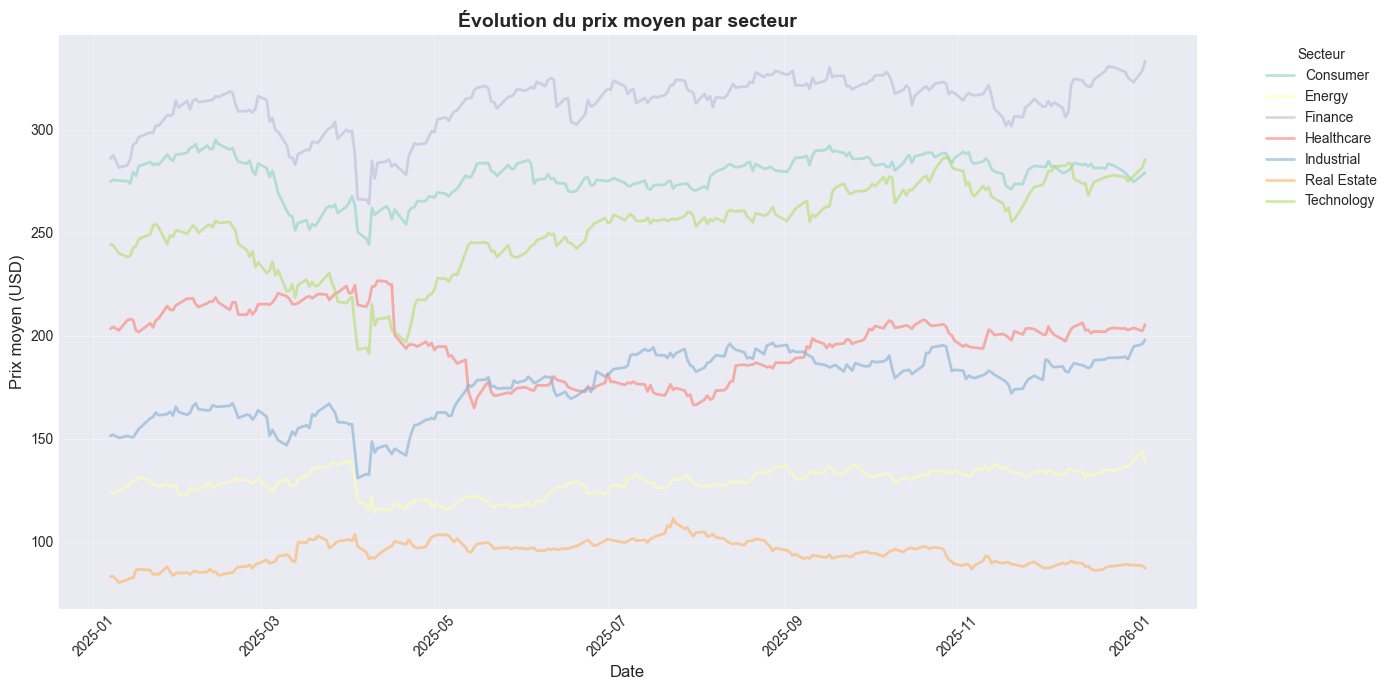

In [10]:
price_timeline = sp500_data.groupby(['date', 'sector'])['close'].mean().reset_index()
price_timeline.columns = ['date', 'sector', 'avg_price']
price_timeline = price_timeline.sort_values('date')

plt.figure(figsize=(14, 7))
for sector in price_timeline['sector'].unique():
    sector_data = price_timeline[price_timeline['sector'] == sector]
    plt.plot(sector_data['date'], sector_data['avg_price'], label=sector, alpha=0.6, linewidth=2)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix moyen (USD)', fontsize=12)
plt.title('Évolution du prix moyen par secteur', fontsize=14, fontweight='bold')
plt.legend(title='Secteur', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## GRAPHIQUE 2 : Évolution du volume de trading par secteur

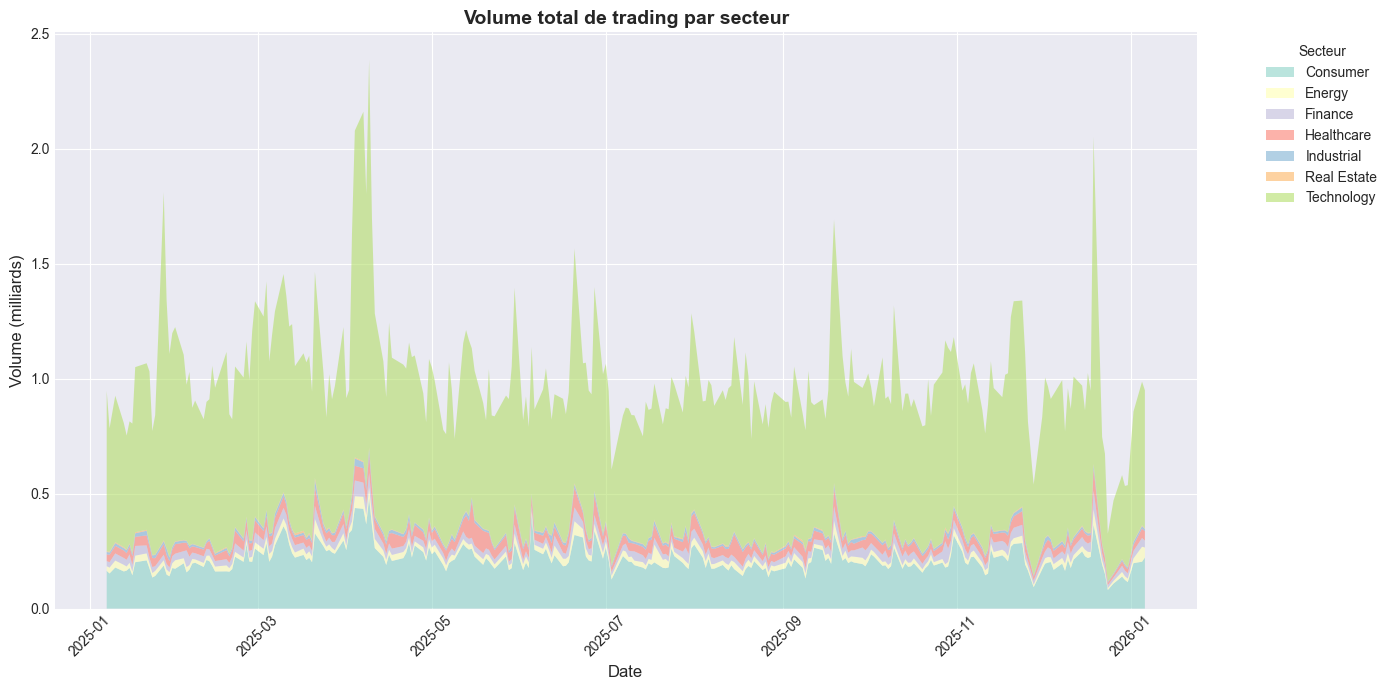

In [11]:
volume_timeline = sp500_data.groupby(['date', 'sector'])['volume'].sum().reset_index()
volume_timeline['total_volume'] = volume_timeline['volume'] / 1e9  # En milliards
volume_timeline = volume_timeline.sort_values('date')

# Créer un graphique en aires empilées
pivot_volume = volume_timeline.pivot(index='date', columns='sector', values='total_volume')

plt.figure(figsize=(14, 7))
plt.stackplot(pivot_volume.index, *[pivot_volume[col] for col in pivot_volume.columns],
              labels=pivot_volume.columns, alpha=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume (milliards)', fontsize=12)
plt.title('Volume total de trading par secteur', fontsize=14, fontweight='bold')
plt.legend(title='Secteur', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## GRAPHIQUE 3 : Heatmap - Rendements par secteur et mois

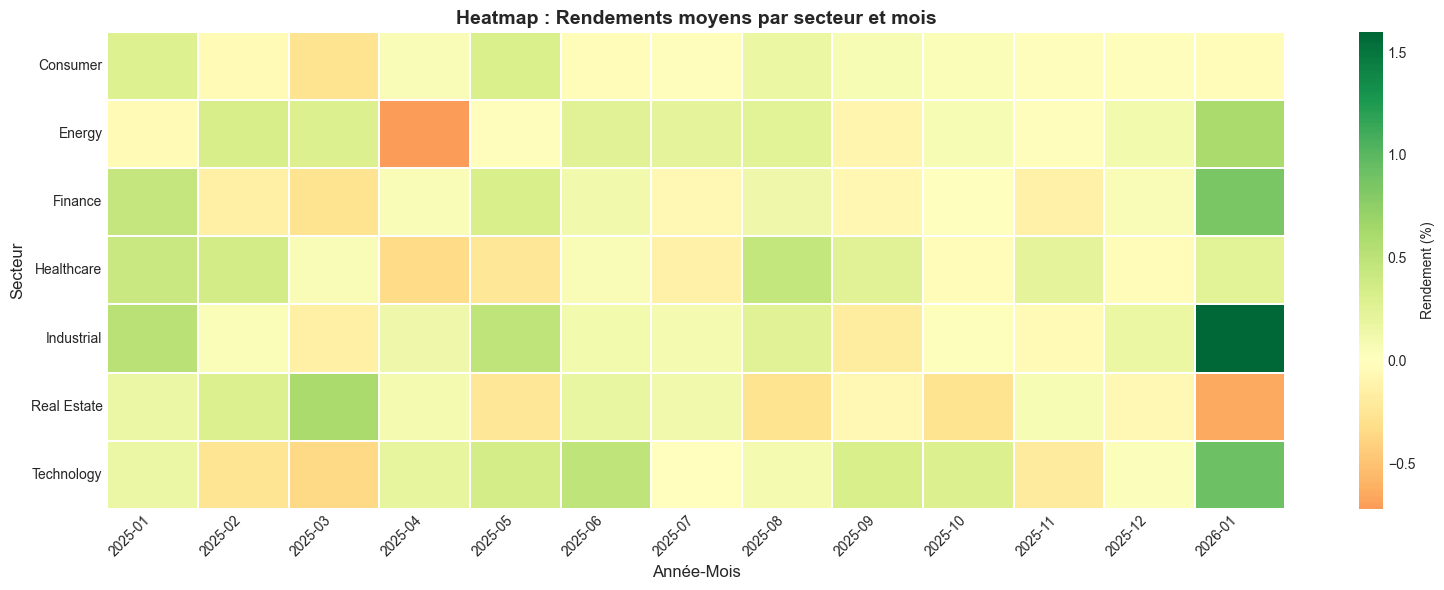

In [12]:
sp500_data_sorted = sp500_data.sort_values(['symbol', 'date'])
sp500_data_sorted['returns'] = sp500_data_sorted.groupby('symbol')['close'].pct_change() * 100
sp500_data_sorted['year_month'] = sp500_data_sorted['date'].dt.to_period('M').astype(str)

returns_heatmap = sp500_data_sorted.groupby(['year_month', 'sector'])['returns'].mean().reset_index()
returns_heatmap.columns = ['year_month', 'sector', 'avg_returns']

pivot_returns = returns_heatmap.pivot(index='sector', columns='year_month', values='avg_returns')

plt.figure(figsize=(16, 6))
sns.heatmap(pivot_returns, cmap='RdYlGn', center=0, annot=False, fmt='.1f',
            cbar_kws={'label': 'Rendement (%)'}, linewidths=0.3, linecolor='white')
plt.title('Heatmap : Rendements moyens par secteur et mois', fontsize=14, fontweight='bold')
plt.xlabel('Année-Mois', fontsize=12)
plt.ylabel('Secteur', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## GRAPHIQUE 4 : Box plot des rendements par secteur

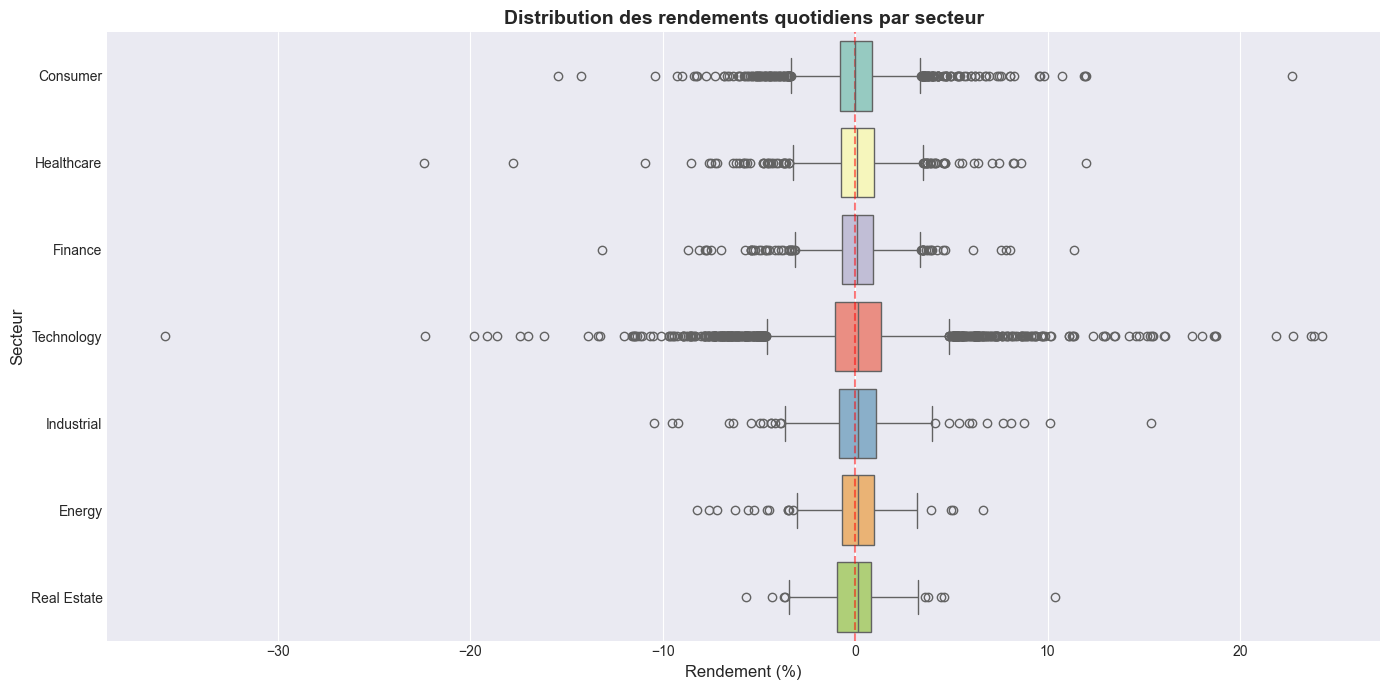

In [13]:
returns_sector = sp500_data_sorted[sp500_data_sorted['returns'].notna()]

plt.figure(figsize=(14, 7))
sector_order = returns_sector.groupby('sector')['returns'].median().sort_values().index
sns.boxplot(data=returns_sector, y='sector', x='returns', order=sector_order, palette='Set3')
plt.xlabel('Rendement (%)', fontsize=12)
plt.ylabel('Secteur', fontsize=12)
plt.title('Distribution des rendements quotidiens par secteur', fontsize=14, fontweight='bold')
plt.axvline(0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## GRAPHIQUE 5 : Évolution du prix des Top 5 actions

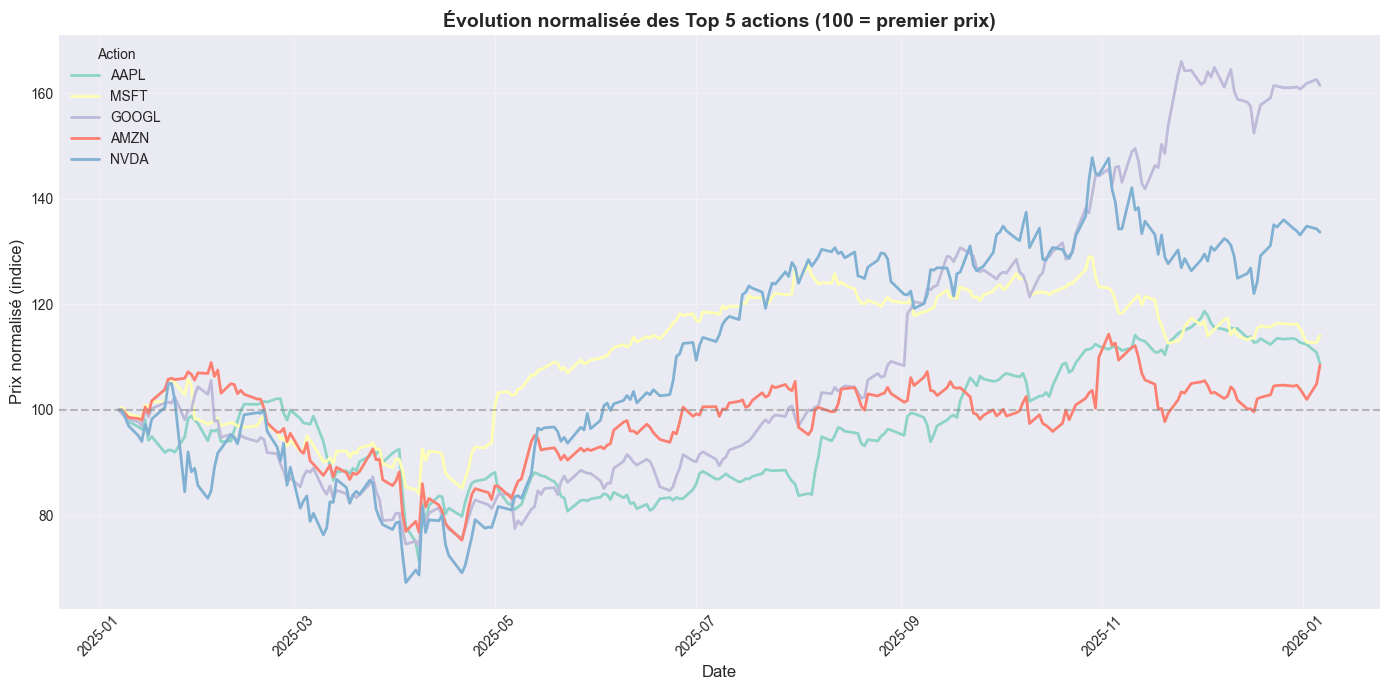


✓ Partie 2 complétée : Analyses temporelles


In [14]:
top_5_symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]
top_5_data = sp500_data[sp500_data['symbol'].isin(top_5_symbols)].copy()

# Normaliser les prix
for symbol in top_5_symbols:
    mask = top_5_data['symbol'] == symbol
    first_price = top_5_data[mask].iloc[0]['close']
    top_5_data.loc[mask, 'normalized_price'] = (top_5_data.loc[mask, 'close'] / first_price) * 100

plt.figure(figsize=(14, 7))
for symbol in top_5_symbols:
    symbol_data = top_5_data[top_5_data['symbol'] == symbol].sort_values('date')
    plt.plot(symbol_data['date'], symbol_data['normalized_price'], label=symbol, linewidth=2)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix normalisé (indice)', fontsize=12)
plt.title('Évolution normalisée des Top 5 actions (100 = premier prix)', fontsize=14, fontweight='bold')
plt.legend(title='Action', loc='best')
plt.xticks(rotation=45)
plt.axhline(100, color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Partie 2 complétée : Analyses temporelles")